# Chapter 4
## Building good training datasets - data preprocessing

Computational tools are generally unable to handle missing values. They should be removed or imputed. 

In [1]:
import pandas as pd
from io import StringIO
csv_data = \
    '''A,B,C,D
    1.0,2.0,3.0,4.0
    5.0,6.0,,8.0
    10.0,11.0,12.0,'''
df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


Easiest way to identify null values is isnull

In [2]:
df.isnull().sum()

A    0
B    0
C    1
D    1
dtype: int64

Scikit-learn was originally built with Numpy and not pandas.  Most functions support dataframe inputs, but not all; therefore, it is usually better to pass a numpy array into scikit-learn functions.

Null values can be dropped via the `dropna` method. Use `axis` to determine rows or columns dropped; `how=all` will drop all columns with only `NaN`.  `thresh` will drop rows with fewer than x real values.  `subset` will drop `NaN` only from specified columns. 

Note that dropping values always represents a possible information loss; too many rows or features might be dropped.

An alternative is to impute values.  Scikit-learn has a `SimpleImputer` class to impute values. Below the mean of the column is imputed for the missing values.  Other strategies can be used; for example, median  or most-common value.  An alternative strategy is is to use `fillna`.  Moreover, more complex algorithms can also be used, such as `KNNImputer`

In [3]:
from sklearn.impute import SimpleImputer
import numpy as np
imr = SimpleImputer(missing_values=np.nan, strategy='mean') 
imr = imr.fit(df.values)
imr.transform(df.values)

array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6. ,  7.5,  8. ],
       [10. , 11. , 12. ,  6. ]])

In [4]:
df.fillna(df.mean())

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,7.5,8.0
2,10.0,11.0,12.0,6.0


In [5]:
from sklearn.impute import KNNImputer
knn_impute = KNNImputer(n_neighbors=2, weights="distance").fit(df)
knn_impute.transform(df)

array([[ 1.        ,  2.        ,  3.        ,  4.        ],
       [ 5.        ,  6.        ,  7.        ,  8.        ],
       [10.        , 11.        , 12.        ,  6.57142857]])

## transformers and estimators API in scikit-learn

Scikit-learn's API uses `transform` and `fit` to transform data. `fit` learns parameters from data and `transform` then changes the data.  All data passed to `transform` needs to have the same number of features as the data passed to `fit`.

Estimators are conceptually similar to transformers.  They have a `fit` and `transform` method; however, they also include a `predict` method.

## handling categorical data

- *ordinal* data: ordered categories, for example grade levels in school
- *nominal* data: no order implied

In [6]:
df = pd.DataFrame([['green', 'M', 10.1, 'class2'],['red', 'L', 13.5, 'class1'],['blue', 'XL', 15.3, 'class2']])
df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class2
1,red,L,13.5,class1
2,blue,XL,15.3,class2


### handling ordinal features

Consider the size column.  It can be manually mapped, and then inversed:

In [7]:
size_mapping = {'M':1, 'L':2, 'XL':3}
df['size'] = df['size'].map(size_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class2
1,red,2,13.5,class1
2,blue,3,15.3,class2


In [8]:
inv_size_mapping = {v: k for k, v in size_mapping.items()}
df['size'] = df['size'].map(inv_size_mapping)
df

,color,size,price,classlabel
0,green,M,10.1,class2
1,red,L,13.5,class1
2,blue,XL,15.3,class2


However, machine learning algorithms generally cannot handle non-numeric values.  Most ML algorithms will convert labels to numeric types internally, but they should be handled beforehand. Use a similar map as above.

In [9]:
class_mapping = {label: idx for idx, label in enumerate(np.unique(df['classlabel']))}
df['classlabel'] = df['classlabel'].map(class_mapping)
df

,color,size,price,classlabel
0,green,M,10.1,1
1,red,L,13.5,0
2,blue,XL,15.3,1


In [10]:
inv_class_mapping = {v: k for k, v in class_mapping.items()}
df['classlabel'] = df['classlabel'].map(inv_class_mapping)
df

,color,size,price,classlabel
0,green,M,10.1,class2
1,red,L,13.5,class1
2,blue,XL,15.3,class2


Scikit-learn also includes `LabelEncoder` that is a transformer:

In [11]:
from sklearn.preprocessing import LabelEncoder
class_le = LabelEncoder()
y = class_le.fit_transform(df['classlabel'].values)
y

array([1, 0, 1])

In [12]:
#it also include the inverse:
class_le.inverse_transform(y)

array(['class2', 'class1', 'class2'], dtype=object)

## Handling nominal categories

Note that if the same techniques above that are used with ordinal data are then used with nominal data, then there is the possibility with some algorithms that the nominal categories are interpreted as ordinal.

A way around this is *one-hot encoding* which to make the nominal categories into a series of boolean columns.  This is done below with the color column.

In [13]:
from sklearn.preprocessing import OneHotEncoder
X = df[['color', 'size', 'price']].values
color_ohe = OneHotEncoder()
color_ohe.fit_transform(X[:, 0].reshape(-1, 1)).toarray() #use slice and reshape to only transform color column

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

`ColumnTransformer` can also be used to passa transformer to only select columns

In [14]:
from sklearn.compose import ColumnTransformer
X = df[['color', 'size', 'price']].values
#only apply the OneHotEncoder to the color column
#passthrough for the other columns
c_transf = ColumnTransformer([
    ('onehot', OneHotEncoder(), [0]),
    ('nothing', 'passthrough', [2])
])
c_transf.fit_transform(df).astype(float)

array([[ 0. ,  1. ,  0. , 10.1],
       [ 0. ,  0. ,  1. , 13.5],
       [ 1. ,  0. ,  0. , 15.3]])

pandas also has a `get_dummies` that performs the same:

In [15]:
pd.get_dummies(df[['price', 'color', 'size']])

,price,color_blue,color_green,color_red,size_L,size_M,size_XL
0,10.1,0,1,0,0,1,0
1,13.5,0,0,1,1,0,0
2,15.3,1,0,0,0,0,1


Note that encoding introduces multi-colinearity which can cause a problem for methods that use matrix inversion.  One way to prevent this is to pass the `drop_first=True` to `get_dummies` and `drop='first'` to OneHotEncoder.

In addition, there are other types of encoding; the following inportant ones are included in the [library `category_encodesr`](https://contrib.scikit-learn.org/category_encoders/):
- [Binary encoding](https://contrib.scikit-learn.org/category_encoders/binary.html) : uses binary features like OneHotEncoder; however, it produces less columns: $\log_2(K) < K-1$ where $K$ is the number of columns.
- [Count encoding](https://contrib.scikit-learn.org/category_encoders/count.html) :  Replaces the category with the count of the category for the column

These do not necessarily perform better than OneHotEncoder or `get_dummies`, but can be considered hyperparameters for a model.

#### Option: encoding ordinal features

Features can be categorized into bins of features.  For example x > M and x > L for shirt sizes.

## Partitioning train and test sets

Use `train_test_split`.  

#### Choosing a good split 
- common splits are 60:40 to 80:20
- larger datasets can be 90:10 to 99:1
- once a model is finalized, it is often retrained on the whole dataset

In [16]:
df_wine = pd.read_csv('wine_data.csv').drop(columns = ['Unnamed: 0'])
df_wine.columns = ['Class label', 'Alcohol',
    'Malic acid', 'Ash',
    'Alcalinity of ash', 'Magnesium',
    'Total phenols', 'Flavanoids',
    'Nonflavanoid phenols',
    'Proanthocyanins',
    'Color intensity', 'Hue',
    'OD280/OD315 of diluted wines',
    'Proline']

In [17]:
from sklearn.model_selection import train_test_split
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values 
X_train, X_test, y_train, y_test = train_test_split(X, y,
                 test_size=0.3,
                 random_state=0,
                 stratify=y)

### Feature scaling

Two common approaches:

1. *normalization* : rescaling features to the range $[0.1]$ for example min-max scaling:
$$
    x_{norm}^{(i)} = \frac{x^{(i)} - x_{min}}{x_{max} - x_{min}}
$$

In [18]:
from sklearn.preprocessing import MinMaxScaler 
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

In [19]:
X_train_norm[:2]

array([[0.64619883, 0.83201581, 0.4248366 , 0.46236559, 0.27160494,
        0.35172414, 0.09704641, 0.68      , 0.18987342, 0.23623446,
        0.45744681, 0.28571429, 0.19400856],
       [0.6871345 , 0.15612648, 0.65359477, 0.43548387, 0.7654321 ,
        0.67931034, 0.50632911, 0.74      , 0.2943038 , 0.3250444 ,
        0.81914894, 0.63369963, 0.68259629]])

2. *standardization* : using the z value

This is better for many optimization algorithms like gradient descent, as then the weights--when initialized--are learned more quickly.  In addition, it retains information about outliers.

It can be performed manually and with `StandardScaler` in scikit-learn

In [20]:
ex = np.array([0, 1, 2, 3, 4, 5])
print('standardized:', (ex - ex.mean()) / ex.std())
print('normalized:', (ex - ex.min()) / (ex.max() - ex.min()))

standardized: [-1.46385011 -0.87831007 -0.29277002  0.29277002  0.87831007  1.46385011]
normalized: [0.  0.2 0.4 0.6 0.8 1. ]


In [21]:
from sklearn.preprocessing import StandardScaler 
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

In [22]:
X_train_std[:2]

array([[ 0.71225893,  2.22048673, -0.13025864,  0.05962872, -0.50432733,
        -0.52831584, -1.24000033,  0.84118003, -1.05215112, -0.29218864,
        -0.20017028, -0.82164144, -0.62946362],
       [ 0.88229214, -0.70457155,  1.17533605, -0.09065504,  2.34147876,
         1.01675879,  0.66299475,  1.0887425 , -0.49293533,  0.13152077,
         1.33982592,  0.54931269,  1.47568796]])

Other options are:
- `RobustScaler`: good for small datasets with many outliers and algorithms that are prone to overfitting
    - Removes median values and scales according to the 1st and 3rd quartile
    
## Selecting meaningful features

When a model does not generalize well, it is said to have *high variance* and that the model fits the training data too closely.  Common solutions are:
- Collect more training data
- regularization to penalize complexity
- simpler model with less parameters
- reduce data dimensionality

### L1 and L2 regularization

L2 regularization:
$$
    \|w\|^2_2 = \sum_{j=1}^m w_j^2
$$
This penalizes large weights.
Alternative L1 regularization
$$
    \|w\|_1 = \sum_{j=1}^m |w_j|
$$

L1 regularization tends to yield sparese feature vectors as most weights will be zero; this can be helpful for high-dimensionality datasets with many irrelevant features.  L1 is then a form of feature selection.

### L2 regularization geometry

Consider the MSE; this is a spherical function (sum of squares of a difference) that we want to minimize.  L2 regularization adds a penalty: $\lambda\|w\|^2_2$ to this loss function; especially large for large weights, making the MSE objective function "harder" to minimize. The larger the $\lambda$, or regularization strength, we shrink weights towards zero to decrease reliance on the training set.  The L2 regularization penalty can be imagined as a sphere; the best value for regularization will therefore be where the L2 ball intersects the unpenalized loss function sphere.

### L1 regularization and sparsity

Instead of a sphere like L2 regularization, L1 uses a diamond with vertices on the axis of the plane.  Therefore, the intersection between the loss function and the L1 function are more likely to be on the axes.

### Adding regularization to models

Use the model's `penalty` parameter.  Note that not all optimization algorithms are compatable with `l1` regularization.

In [23]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l1', C=1.0, solver='liblinear', multi_class='ovr')
lr.fit(X_train_std, y_train)
print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))

Training accuracy: 1.0
Test accuracy: 1.0


Note that each intercept represents a fit to each class prediction as logistic regression uses a OvR for multiclass predictions.

In [24]:
lr.intercept_ #this corresponds to the bias unit

array([-1.26389344, -1.21542712, -2.37119006])

The corresponding weights for each class show how only some of the features are selected.

In [25]:
lr.coef_ #this is the weights vector

array([[ 1.24618631,  0.18040846,  0.74616855, -1.16373131,  0.        ,
         0.        ,  1.16015323,  0.        ,  0.        ,  0.        ,
         0.        ,  0.55777749,  2.50854125],
       [-1.5396405 , -0.38542762, -0.99587866,  0.36389711, -0.05897135,
         0.        ,  0.66687406,  0.        ,  0.        , -1.93127088,
         1.23875662,  0.        , -2.2328428 ],
       [ 0.13576164,  0.16881011,  0.35729309,  0.        ,  0.        ,
         0.        , -2.43727019,  0.        ,  0.        ,  1.56311626,
        -0.81769926, -0.49384015,  0.        ]])

Note that the weights are not sparse: more have non-zero values. More sparsity can be enforced by choosing a low `C` (inverse of the regularization strength) parameter.  Note in the graph below that a strong $\lambda$ makes more of the parameters have weights of 0

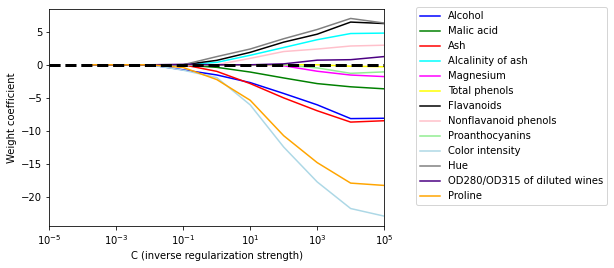

In [26]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.subplot(111)
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'pink', 'lightgreen', 'lightblue', 'gray', 'indigo', 'orange']
weights, params = [], []
for c in np.arange(-4., 6.):
    lr = LogisticRegression(penalty='l1', C=10.**c,solver='liblinear', multi_class='ovr', random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1]) 
    params.append(10**c)
weights = np.array(weights)
for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],label=df_wine.columns[column + 1], color=color)
plt.axhline(0, color='black', linestyle='--', linewidth=3) 
plt.xlim([10**(-5), 10**5])
plt.ylabel('Weight coefficient')
plt.xlabel('C (inverse regularization strength)') 
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center', bbox_to_anchor=(1.38, 1.03), ncol=1, fancybox=True) 
plt.show()

## Sequential feature selection algorithm

- *dimensionality reduction* can help prevent overfitting.  There are two types:
    - *feature selection* : select a subset of features
    - *feature extraction* : derive information from features to make a new feature subspace
- this is useful in algorithms that do not support regularization

Sequential feature extraction tries to reduce a $d$-dimensional space to a $k$-dimensional space where $d > k$.  This is done by algorthmically selecting a subset of meaningful features.  A common algorithm is *sequential backward selection*; sequential backward selection uses a criterion function, $J$, that is minimized to remove features until a desired size subset is formed.

The algorithm is summarized as follows:
1. Initialize with $k=d$ where $d$ is the dimensionality of the full feature space, $X_d$
2. Determine the feature, $x^-$, which maximizes $\text{argmax}J(X_k - X)$ where $x \in X_k$
3. Remove $x^-$ and set $X_{k-1} = X_k - x^-$ and $k = k-1$
4. Continue or terminate if $k$ is the desired dimensionality

### Implementing sequential backward selection in python

In [31]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

class SBS:
    def __init__(self, estimator, k_features, scoring=accuracy_score, test_size = 0.25, random_state=1):
        self.scoring = scoring #scoring metric
        self.estimator = clone(estimator) #model used
        self.k_features = k_features #number of features to reduce to
        self.test_size = test_size #split size
        self.random_state = random_state
        
    def fit(self, X, y):
        #split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = self.test_size, random_state = self.random_state)
        #outside of the wile loop, the algorithm is initialized with k = d
        #get dimenstions of the feature space
        dim = X_train.shape[1]
        #make indices
        self.indices_ = tuple(range(dim))
        #get the subsets of indices
        self.subsets_ = [self.indices_]
        #score the initial whole set.  this is used to evaluate the subsets
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
        self.scores_ = [score]
        # while loop will run until the number of dimensions is reduced to 
        # the desired k_features
        while dim > self.k_features:
            scores = []
            subsets = []
            #feature subsets; get a combination of features that is size r
            for p in combinations(self.indices_, r = dim -1):
                #score the subset
                score = self._calc_score(X_train, y_train, X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
            #calculate the inputs of the best scoring
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            #reduce until dim = k_features
            dim -= 1
            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]
        return self
    
    def transform(self, X):
        return X[:, self.indices_]
    
    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

Note that even though there is a test/train split in the SBS class, the dataset passed to the class is already split. This prevents leaking the original test data into the training of a model.  

The KNN algorithm looks like it just needs three features:

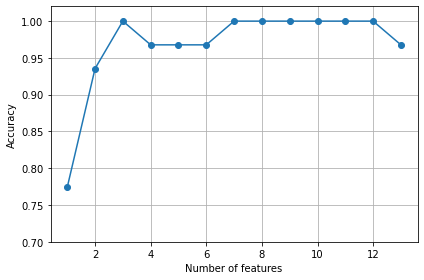

In [33]:
from sklearn.neighbors import KNeighborsClassifier 
knn = KNeighborsClassifier(n_neighbors=5)
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

#see how the algorithm performs for each subset of the features
k_feat = [len(k) for k in sbs.subsets_] 
plt.plot(k_feat, sbs.scores_, marker='o') 
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features') 
plt.grid()
plt.tight_layout()
plt.show()

What are these three features?

In [34]:
k3 = list(sbs.subsets_[10]) 
print(df_wine.columns[1:][k3])

Index(['Alcohol', 'Malic acid', 'OD280/OD315 of diluted wines'], dtype='object')


Evaluate on the orignal data set:

In [35]:
#for all the features
knn.fit(X_train_std, y_train)
print('Training accuracy:', knn.score(X_train_std, y_train))
print('Test accuracy:', knn.score(X_test_std, y_test))

Training accuracy: 0.967741935483871
Test accuracy: 0.9629629629629629


In [36]:
#for the 3 best features
knn.fit(X_train_std[:, k3], y_train)
print('Training accuracy:', knn.score(X_train_std[:, k3], y_train))
print('Test accuracy:',knn.score(X_test_std[:, k3], y_test))

Training accuracy: 0.9516129032258065
Test accuracy: 0.9259259259259259


Even though there is a decline in the accuracy, the dimensions are reduced from 14 features to 3.  Not only does less data need to be collected, but the computational complexity is decreased.

## Feature importance using random forests

Feature importance here is the average impurity decrease for a feature over dataset. The `RandomForestClassifier` in scikit-learn has the attribute `feature_importances_` that can be accessed.

In [39]:
from sklearn.ensemble import RandomForestClassifier 
feat_labels = df_wine.columns[1:]
forest = RandomForestClassifier(n_estimators=500, random_state=1)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
    feat_labels[indices[f]],
    importances[indices[f]]))

 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529
 6) Hue                            0.058739
 7) Total phenols                  0.050872
 8) Magnesium                      0.031357
 9) Malic acid                     0.025648
10) Proanthocyanins                0.025570
11) Alcalinity of ash              0.022366
12) Nonflavanoid phenols           0.013354
13) Ash                            0.013279


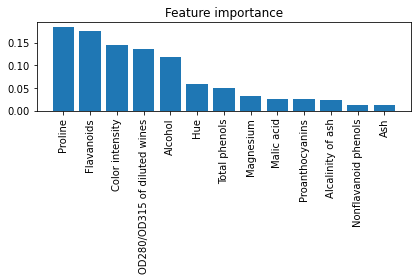

In [40]:
plt.title('Feature importance')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation=90) 
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

Note the overlap with SBS: 2 of the top 5 random features are shared.  Note however that impurity might not catch highly correlated features. 

Scikit-learn also implements `SelectFromModel` to select features from a set threshold; this can be used as a feature selector in a pipeline.  For example, if a Random Forest is used as a feature selector for another model.

In [43]:
from sklearn.feature_selection import SelectFromModel 
sfm = SelectFromModel(forest, threshold=0.1, prefit=True) 
X_selected = sfm.transform(X_train)
print(f'Number of features that meet this threshold criterion: {X_selected.shape[1]}')
for f in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                        feat_labels[indices[f]],
                        importances[indices[f]]))

Number of features that meet this threshold criterion: 5
 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529
